In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))
import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread
import torch.nn as nn
import numpy as np
from skimage import img_as_ubyte
import imageio
from tqdm import tqdm_notebook
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes
from PIL import Image  
import time
# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights,
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    look_at_rotation,
    SoftSilhouetteShader,
    BlendParams
)
import skimage

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

from datetime import datetime
import os
def now_str():
    now = datetime.now()
    month = str(now.month)
    day = str(now.day)
    hour = str(now.hour)
    minute = str(now.minute)
    sec = str(now.second)
    
    output = '[{:>02}/{:>02} {:>02}:{:>02}:{:>02}]'.format(month, day, hour, minute, sec)
    return output
print(now_str())
print('python:', sys.version)
print('torch :', torch.__version__)
print('cuda  :', torch.version.cuda)
%load_ext autoreload
%autoreload 2

[04/15 02:14:48]
python: 3.8.1 (default, Mar  2 2020, 13:06:26) [MSC v.1916 64 bit (AMD64)]
torch : 1.4.0
cuda  : 9.2
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model

(512, 512, 4)


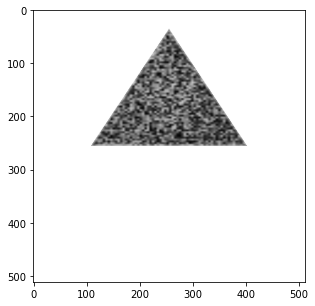

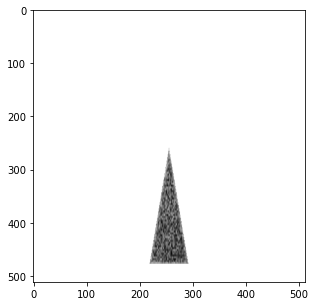

In [6]:
import math
class GaussianLayer(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device = device
        self.conv = None
        # Given groups=3, weight of size 3 1 3 3, expected input[1, 512, 512, 4] to have 3 channels, but got 512 channels instead
        
    def forward(self, x, kernel_size, sigma, channels=4):
        if self.conv is None:
            self.conv = self._get_gaussian_conv2d(kernel_size, sigma)
        gaussian_kernel = self._generate_gaussian_kernel(kernel_size=kernel_size, sigma=sigma, channels=channels)
        self.conv.weight.data = gaussian_kernel
        self.conv.padding = int(kernel_size/2)
        out = self.conv(x)
        return out
    
    def _generate_gaussian_kernel(self, kernel_size, sigma, channels=4):
        # Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
        x_cord = torch.arange(kernel_size)
        x_grid = x_cord.repeat(kernel_size).view(kernel_size, kernel_size)
        y_grid = x_grid.t()
        xy_grid = torch.stack([x_grid, y_grid], dim=-1)

        mean = (kernel_size - 1)/2.
        variance = sigma**2.

        # Calculate the 2-dimensional gaussian kernel which is
        # the product of two gaussian distributions for two different
        # variables (in this case called x and y)
        gaussian_kernel = (1./(2.*math.pi*variance)) * torch.exp(-torch.sum((xy_grid - mean)**2., dim=-1) / (2*variance + 0.00001))
        
#         gaussian_kernel = torch.sum((xy_grid - mean)**2, dim=-1)
        # Make sure sum of values in gaussian kernel equals 1.
        gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)
        # Reshape to 2d depthwise convolutional weight
        gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
        gaussian_kernel = gaussian_kernel.repeat(channels, 1, 1, 1).to(self.device)
        
        return gaussian_kernel
    
    def _get_gaussian_conv2d(self, kernel_size, sigma, channels=4):
        gaussian_filter = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=kernel_size, stride=1, padding=int(kernel_size/2), groups=channels, bias=False).to(self.device)
        
        gaussian_kernel = self._generate_gaussian_kernel(kernel_size=kernel_size, sigma=sigma, channels=channels)
        gaussian_filter.weight.data = gaussian_kernel
        gaussian_filter.weight.requires_grad = False
        return gaussian_filter
            
class Model(nn.Module):
    def __init__(self, in_dict):
        super().__init__()
        
        self.render_bg = in_dict['render_bg']
        
        self.device = in_dict['device']
        self.camera = in_dict['camera']
        self.texturemap_size = in_dict['texturemap_size']
        self.image_size = in_dict['image_size']
        mesh_paths = in_dict['mesh_paths']
        texture_map_np = np.random.rand(1, texturemap_size, texturemap_size, 1).astype(np.float32)
        texture_map_np /= np.max(texture_map_np)
        texture_map_image = Image.fromarray(texture_map_np.squeeze())
        self.texture_map = torch.from_numpy(texture_map_np)
       
        
        meshes = load_objs_as_meshes(mesh_paths, device=self.device, universal_texturemap=self.texture_map)
        self.mesh_curr = meshes[0]
        self.mesh_target = meshes[1]
        
        # give initial deform to target
        initial_deform_verts = torch.from_numpy(np.float32([[-0.75, -1.5, 0], [0.75, -1.5, 0], [0, -1.0, 0]])).to(self.device)
        self.mesh_target = self.mesh_target.offset_verts(initial_deform_verts)
        
        self.deform_verts = nn.Parameter(\
            torch.from_numpy(np.zeros(self.mesh_curr.verts_packed().shape, dtype=np.float32)).to(self.device),\
            requires_grad=True)

        self.renderer, self.silhouette_renderer = self.init_renderers()
        
        image_target, _ = self.renderer(meshes_world=self.mesh_target)
        self.image_target_original = image_target.clone()
        self.image_target = image_target.clone()
        
        if self.render_bg:
            bg = np.asarray(texture_map_image.resize((image_size, image_size)))
            bg = np.dstack([bg, bg, bg])
            self.bg = torch.from_numpy(bg).to(self.device)
            self.image_target = self.merge_fg_bg(self.image_target, self.bg)
            
        # gaussian filter
        self.gaussian = GaussianLayer(device=self.device)
        
        
    def forward(self, kernel_size, sigma):
        deformed_mesh = self.mesh_curr.offset_verts(self.deform_verts)
        image, _ = self.renderer(meshes_world=deformed_mesh)
        if self.render_bg:
            image = self.merge_fg_bg(image, self.bg)
        
        if kernel_size > 1:
            image_target = self.image_target_original.clone().transpose(3, 1).transpose(2, 3)
            image_target = self.gaussian(image_target, kernel_size=kernel_size, sigma=sigma)
            self.image_target = image_target.transpose(3, 1).transpose(1, 2)

            image = image.transpose(3, 1).transpose(2, 3)
            image = self.gaussian(image, kernel_size=kernel_size, sigma=sigma)
            image = image.transpose(3, 1).transpose(1, 2)
        
        loss = torch.mean((image - self.image_target)**2)
        diff = image - self.image_target
        return loss, image, diff
    
    def init_renderers(self):
        raster_settings = RasterizationSettings(
            image_size=self.image_size, 
            blur_radius=0.0, 
            faces_per_pixel=1, 
            bin_size = 0,  # this setting controls whether naive or coarse-to-fine rasterization is used
            max_faces_per_bin = None  # this setting is for coarse rasterization
        )

        renderer = MeshRenderer(
            rasterizer=MeshRasterizer(
                cameras=self.camera, 
                raster_settings=raster_settings
            ),
            shader=TexturedSoftPhongShader(
                device=self.device, 
                cameras=self.camera,
                lights=None
            )
        )

        # for silhouette
        blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
        silhouette_renderer = MeshRenderer(
            rasterizer=MeshRasterizer(
                cameras=self.camera, 
                raster_settings=raster_settings
            ),
            shader=SoftSilhouetteShader(blend_params=blend_params)
        )
        return renderer, silhouette_renderer
    
    def merge_fg_bg(self, fg, bg):
        pixel_max = torch.max(fg)
#         red = torch.from_numpy(np.dstack([np.ones((self.image_size, self.image_size)), np.zeros((self.image_size, self.image_size)), np.zeros((self.image_size, self.image_size))]).astype(np.float32)).to(self.device)
        out = torch.where(fg[...,:3] < pixel_max, fg[...,:3], bg)
        return out

device = torch.device("cuda:0")
torch.cuda.set_device(device)
obj_path_curr = '8_data/input/tetrahedron.obj'
# obj_path_target = '8_data/input/tetrahedron_target.obj'
obj_path_target = obj_path_curr
image_size = 512
texturemap_size = 64

R, T = look_at_view_transform(3, 0, 0) 
camera = OpenGLPerspectiveCameras(device=device, R=R, T=T)
in_dict = {'render_bg': False, 'device': device, 'camera': camera, 'texturemap_size': texturemap_size, 'image_size': image_size, 'mesh_paths': [obj_path_curr, obj_path_target]}
model = Model(in_dict)

# image_target = model.image_target.squeeze().cpu().numpy()
# image_target = np.clip(image_target, 0.0, 1.0)
# plt.figure(figsize=(5, 5))
# plt.imshow(image_target, cmap='gray', vmin=0.0, vmax=1.0)
# plt.title(np.max(image_target))
# plt.show()

kernel_size = 0
sigma = 0
loss, image_rendered, diff = model(kernel_size=kernel_size, sigma=sigma)
diff = diff.detach().squeeze().cpu().numpy() 
print(diff.shape)
image_rendered = image_rendered.detach().squeeze().cpu().numpy()
# image_rendered = np.clip(image_rendered, 0.0, 1.0)
plt.figure(figsize=(5, 5))
plt.imshow(image_rendered, cmap='gray')
plt.show()

image_target = model.image_target_original.detach().squeeze().cpu().numpy()
plt.figure(figsize=(5, 5))
plt.imshow(image_target, cmap='gray')
plt.show()
# print(log)

<IPython.core.display.Javascript object>


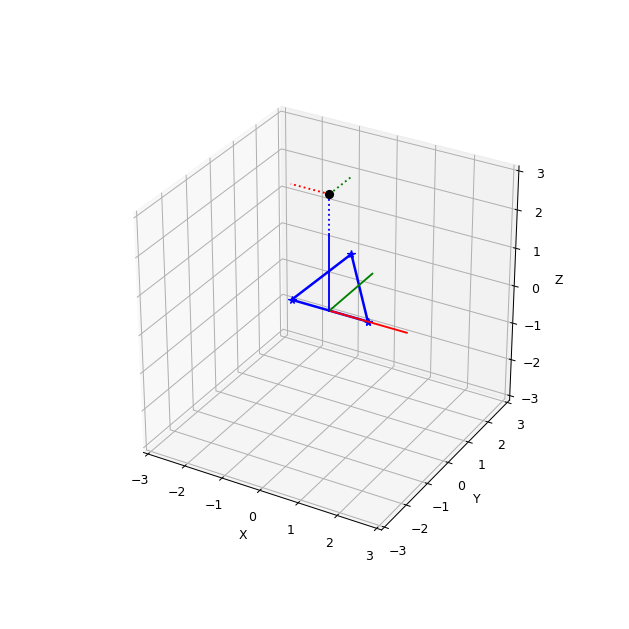

In [7]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

# current mesh
vs = model.mesh_curr.verts_packed().cpu().numpy()
vs = np.vstack([vs, vs[0, :]])
ax.plot(vs[:,0], vs[:,1], vs[:,2], linewidth=2, c='b', marker='*')

# target mesh
# vs = model.mesh_target.verts_packed().cpu().numpy()
# vs = np.vstack([vs, vs[0, :]])
# ax.plot(vs[:,0], vs[:,1], vs[:,2], linewidth=2, c='r', marker='*')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
L = 3
ax.set_xlim([-L, L])
ax.set_ylim([-L, L])
ax.set_zlim([-L, L])
L = 2
ax.plot([0, L], [0, 0], [0, 0], c='r')
ax.plot([0, 0], [0, L], [0, 0], c='g')
ax.plot([0, 0], [0, 0], [0, L], c='b')

t = model.camera.get_camera_center().squeeze().cpu().numpy()

# camera
t = T.squeeze().cpu().numpy()
r = R.squeeze().cpu().numpy()

# to pose
t = -r.T.dot(t)
# t = -r.dot(t)
r = r.T

ax.scatter(t[0], t[1], t[2], c='k', marker='o', s=40)
L = 1
Xc_axis = t + r.dot(np.float32([L, 0, 0]))
Yc_axis = t + r.dot(np.float32([0, L, 0]))
Zc_axis = t + r.dot(np.float32([0, 0, L]))
ax.plot([t[0], Xc_axis[0]], [t[1], Xc_axis[1]], [t[2], Xc_axis[2]], c='r', linestyle=':')
ax.plot([t[0], Yc_axis[0]], [t[1], Yc_axis[1]], [t[2], Yc_axis[2]], c='g', linestyle=':')
ax.plot([t[0], Zc_axis[0]], [t[1], Zc_axis[1]], [t[2], Zc_axis[2]], c='b', linestyle=':')
plt.show()

<IPython.core.display.Javascript object>


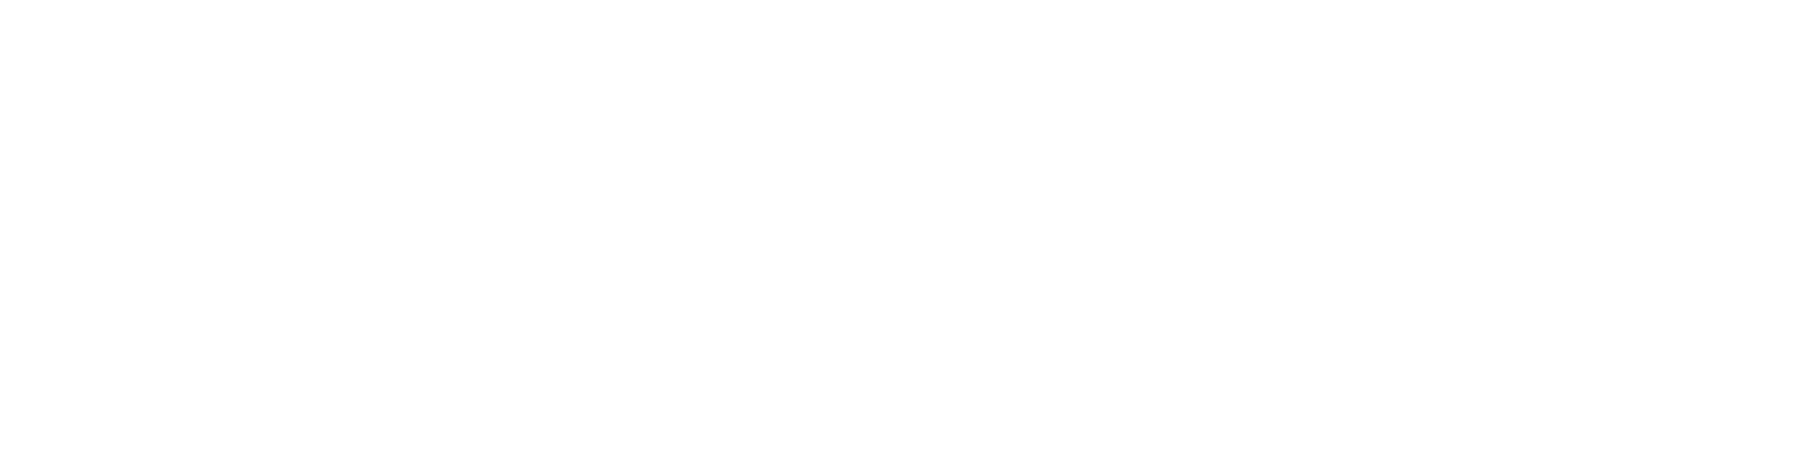

<IPython.core.display.Javascript object>


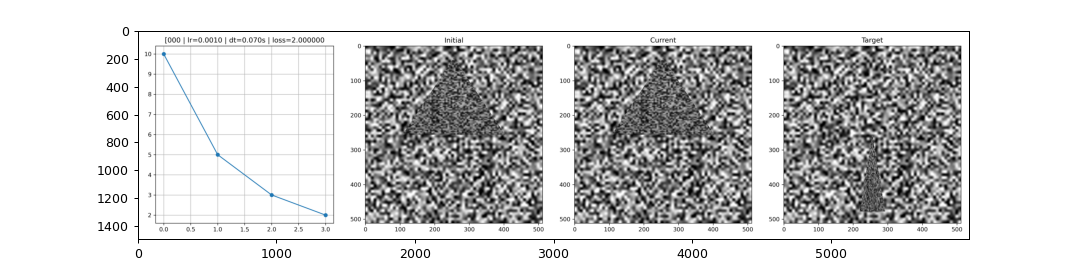

In [8]:
def render_images(epoch, losses, lr, dsec, img1, img2, img3, save_path):
    img1 = np.clip(img1, 0.0, 1.0)
    img2 = np.clip(img2, 0.0, 1.0)
    img3 = np.clip(img3, 0.0, 1.0)
    plt.figure(figsize=(20, 5), tight_layout=True)
    plt.subplot(1, 4, 1)
    plt.plot(losses, '-o')
    plt.grid('on')
    plt.title('[{:03} | lr={:.4f} | dt={:.3f}s | loss={:.6f}'.format(epoch, lr, dsec, losses[-1]))
    
    plt.subplot(1, 4, 2)
    plt.imshow(img1, vmin=0, vmax=1.0), plt.title('Initial')
    
    plt.subplot(1, 4, 3)
    plt.imshow(img2, vmin=0, vmax=1.0), plt.title('Current')
    
    plt.subplot(1, 4, 4)
    plt.imshow(img3, vmin=0, vmax=1.0), plt.title('Target')
    
    plt.savefig(save_path, dpi=300)
    plt.close('all')
    
    saved_img = imageio.imread(save_path)
    return saved_img

def render_images4(epoch, losses, lr, dsec, img1, img2, img3, img4, save_path):
    img1 = np.clip(img1, 0.0, 1.0)
    img2 = np.clip(img2, 0.0, 1.0)
    img3 = np.clip(img3, 0.0, 1.0)
    plt.figure(figsize=(20, 5), tight_layout=True)
    plt.subplot(1, 5, 1)
    plt.plot(losses, '-o')
    plt.grid('on')
    plt.title('[{:03} | lr={:.4f} | dt={:.3f}s | loss={:.6f}'.format(epoch, lr, dsec, losses[-1]))
    
    plt.subplot(1, 5, 2)
    plt.imshow(img1, vmin=0, vmax=1.0), plt.title('Initial')
    
    plt.subplot(1, 5, 3)
    plt.imshow(img2, vmin=0, vmax=1.0), plt.title('Current')
    
    plt.subplot(1, 5, 4)
    plt.imshow(img3, vmin=0, vmax=1.0), plt.title('Blurred Target')
    
    plt.subplot(1, 5, 5)
    plt.imshow(img4, vmin=0, vmax=1.0), plt.title('Original target')
    
    plt.savefig(save_path, dpi=300)
    plt.close('all')
    
    saved_img = imageio.imread(save_path)
    return saved_img

t0 = time.time()
in_dict['render_bg'] = True
model = Model(in_dict)
_, image_rendered, _ = model(kernel_size=0, sigma=0)
image_initial = image_rendered.detach().squeeze().cpu().numpy()
image_target = model.image_target.clone().detach().squeeze().cpu().numpy()
save_path = './8_data/output/temp_plot.png'
t1 = time.time()
lr = 0.001
image = render_images(0, [10, 5, 3, 2], lr, t1-t0, image_initial, image_initial, image_target, save_path)

plt.figure(figsize=(12, 3))
plt.imshow(image)
plt.show()


# Train

In [9]:
%matplotlib inline
kernel_size = 0
sigma = 0

model = Model(in_dict)
_, image_rendered, _ = model(kernel_size=0, sigma=sigma)
image_initial = image_rendered.detach().squeeze().cpu().numpy()
image_target = model.image_target.clone().detach().squeeze().cpu().numpy()
image_target_original = model.image_target_original.clone().detach().squeeze().cpu().numpy()
save_path = './8_data/output/temp_plot.png'

# timestamp
now = datetime.now()
hour = str(now.hour)
minute = str(now.minute)
date_str = '{}{:>02}{:>02}_{:>02}h{:>02}m'.format(now.year, now.month, now.day, hour, minute)
filename_output = "./8_data/output/{}.gif".format(date_str)
writer = imageio.get_writer(filename_output, mode='I', duration=0.01)

loop = tqdm_notebook(range(10000))

losses = []
lr = 1
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


for i in loop:
    mark = i % 10 == 0
    t0 = time.time()

    optimizer.zero_grad()

    if i > 0:
        if i < 40:
            if i % 20 == 0:
                kernel_size = int(kernel_size / 1.25)
                sigma = int(sigma / 1.25)
        else:
            if i % 20 == 0:
                kernel_size = int(kernel_size / 1.25)
                sigma = int(sigma / 1.25)
                
        
        
    loss, image_rendered, _ = model(kernel_size=kernel_size, sigma=sigma)
    
    loop.set_description('[{}/{}] loss {:.6f}'.format(i, len(loop), loss.data))
    
    loss.backward()
    
    optimizer.step()
    
    t1 = time.time()
    dsec = t1-t0
    t0 = t1
    
    if mark:
        losses.append(loss)
        print('e={}, loss={:.6f}, kernel_size={}'.format(i, loss, kernel_size))
        image_target = model.image_target.clone().detach().squeeze().cpu().numpy()
        image_out = image_rendered.detach().squeeze().cpu().numpy()
        # image_out = render_images(i, losses, lr, dsec, image_initial, image_out, image_target, save_path)
        image_out = render_images4(i, losses, lr, dsec, image_initial, image_out, image_target, image_target_original, save_path)
        image_out = skimage.img_as_ubyte(image_out)
        writer.append_data(image_out)
        plt.imshow(image_out)
        plt.show()
        
writer.close()



<ipython-input-9-e00b36b4fc5f>:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  loop = tqdm_notebook(range(10000))


e=0, loss=0.014252, kernel_size=0


KeyboardInterrupt: 

In [ ]:
writer.close()


In [ ]:
plt.plot(losses)
plt.show()

# Compress gif

In [ ]:
from pygifsicle import optimize
path = r'.\8_data\output\yes_bg_local_min2.gif'
print(os.path.exists(path))
optimize(path, r'.\8_data\output\yes_bg_local_min2__.gif')
